In [101]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

random_state = 69420
np.random.seed(random_state)

test_size = 0.2

In [60]:
import os.path
from IPython.display import display, Image

def pairplot_or_image(data, img_path, target, overwrite=False, diag_kind="auto"):
    if os.path.isfile(img_path) and not overwrite:
        display(Image(filename=img_path))
    else:
        pplot = sns.pairplot(data, hue=target, diag_kind=diag_kind)
        pplot.figure.savefig(img_path)

Very useful details on required domain knowledge [here](https://www.kaggle.com/competitions/playground-series-s3e17/discussion/416765)

## Data preparation

In [61]:
data = pd.read_csv("data/train.csv")
data.set_index("id", inplace=True)

print(f"Total size: {len(data)}")

Total size: 136429


The target class is the "Machine failure" attribute

In [62]:
target = "Machine failure"

data[target] = data[target].astype("category")

In [63]:
data[target].value_counts()

Machine failure
0    134281
1      2148
Name: count, dtype: int64

The "Product ID" attribute is irrelevant for this project

In [64]:
data.drop(columns=["Product ID"], inplace=True)

Converting the "type" attribute from categorical to numerical

In [65]:
"""data["Type"] = data["Type"].astype("category")
data["Type"] = data["Type"].cat.codes"""

data.drop(columns=["Type"], axis=1, inplace=True)

This dataset was artificially generated [from another one](https://www.kaggle.com/datasets/dineshmanikanta/machine-failure-predictions/data), so there are (very) few inconsistencies. Namely, the TWF,HDF,PWF,OSF and RNF columns indicate the type of failure (see [here](https://www.kaggle.com/competitions/playground-series-s3e17/discussion/416765)) but we can find a small number of rows that have failure indicators set to 1 (i.e., the machine failed) but the class attribute set to 0 (i.e., the machine didn't fail)

These inconsistent rows, and later the failure type attributes, have to be removed

In [66]:
# Find rows with target==0 and TWF or HDF or PWF or OSF or RNF == 1
# These rows are not valid
invalid = data[(data[target] == 0) & (data["TWF"] == 1)].index
invalid = invalid.append(data[(data[target] == 0) & (data["HDF"] == 1)].index)
invalid = invalid.append(data[(data[target] == 0) & (data["PWF"] == 1)].index)
invalid = invalid.append(data[(data[target] == 0) & (data["OSF"] == 1)].index)
invalid = invalid.append(data[(data[target] == 0) & (data["RNF"] == 1)].index)

print(f"Invalid {len(invalid)}")
# Remove them
data.drop(invalid, inplace=True)

# Remove TWF, HDF, PWF, OSF, RNF columns
data.drop(columns=["TWF", "HDF", "PWF", "OSF", "RNF"], inplace=True)

Invalid 315


In [67]:
data.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
count,136114.000000,136114.000000,136114.000000,136114.000000,136114.000000
mean,299.862308,309.940786,1520.341934,40.344819,104.414278
std,1.862178,1.385134,138.595286,8.496781,63.964527
min,295.300000,305.800000,1181.000000,3.800000,0.000000
25%,298.300000,308.700000,1432.000000,34.600000,48.000000
50%,300.000000,310.000000,1493.000000,40.400000,106.000000
75%,301.200000,310.900000,1580.000000,46.100000,159.000000
max,304.400000,313.800000,2886.000000,76.600000,253.000000


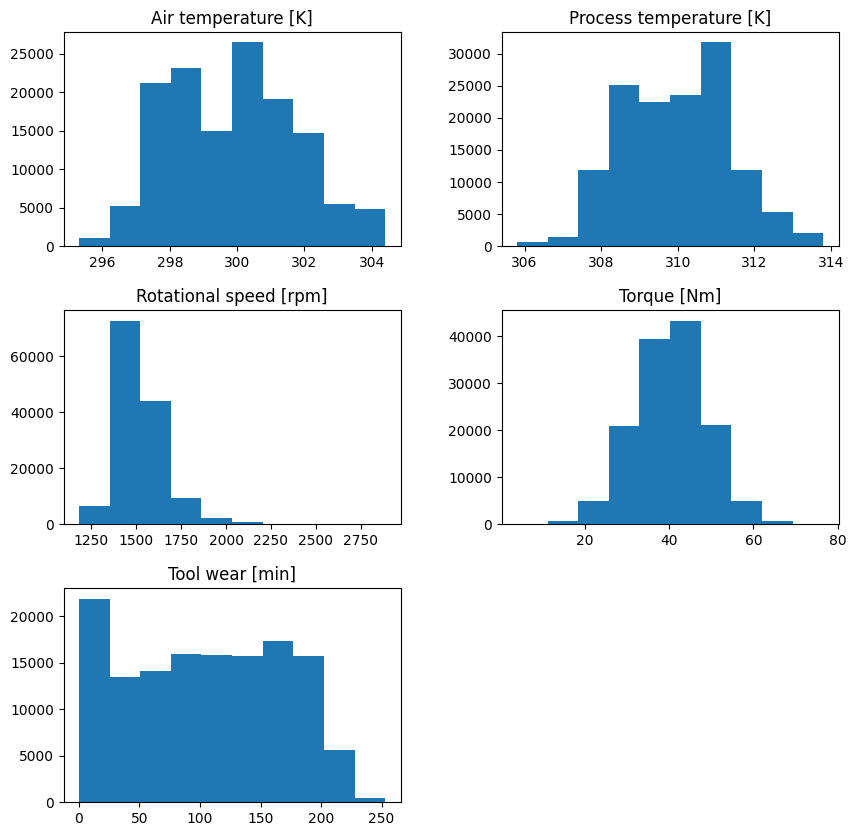

In [68]:
data.hist(figsize=(10, 10), grid=False);

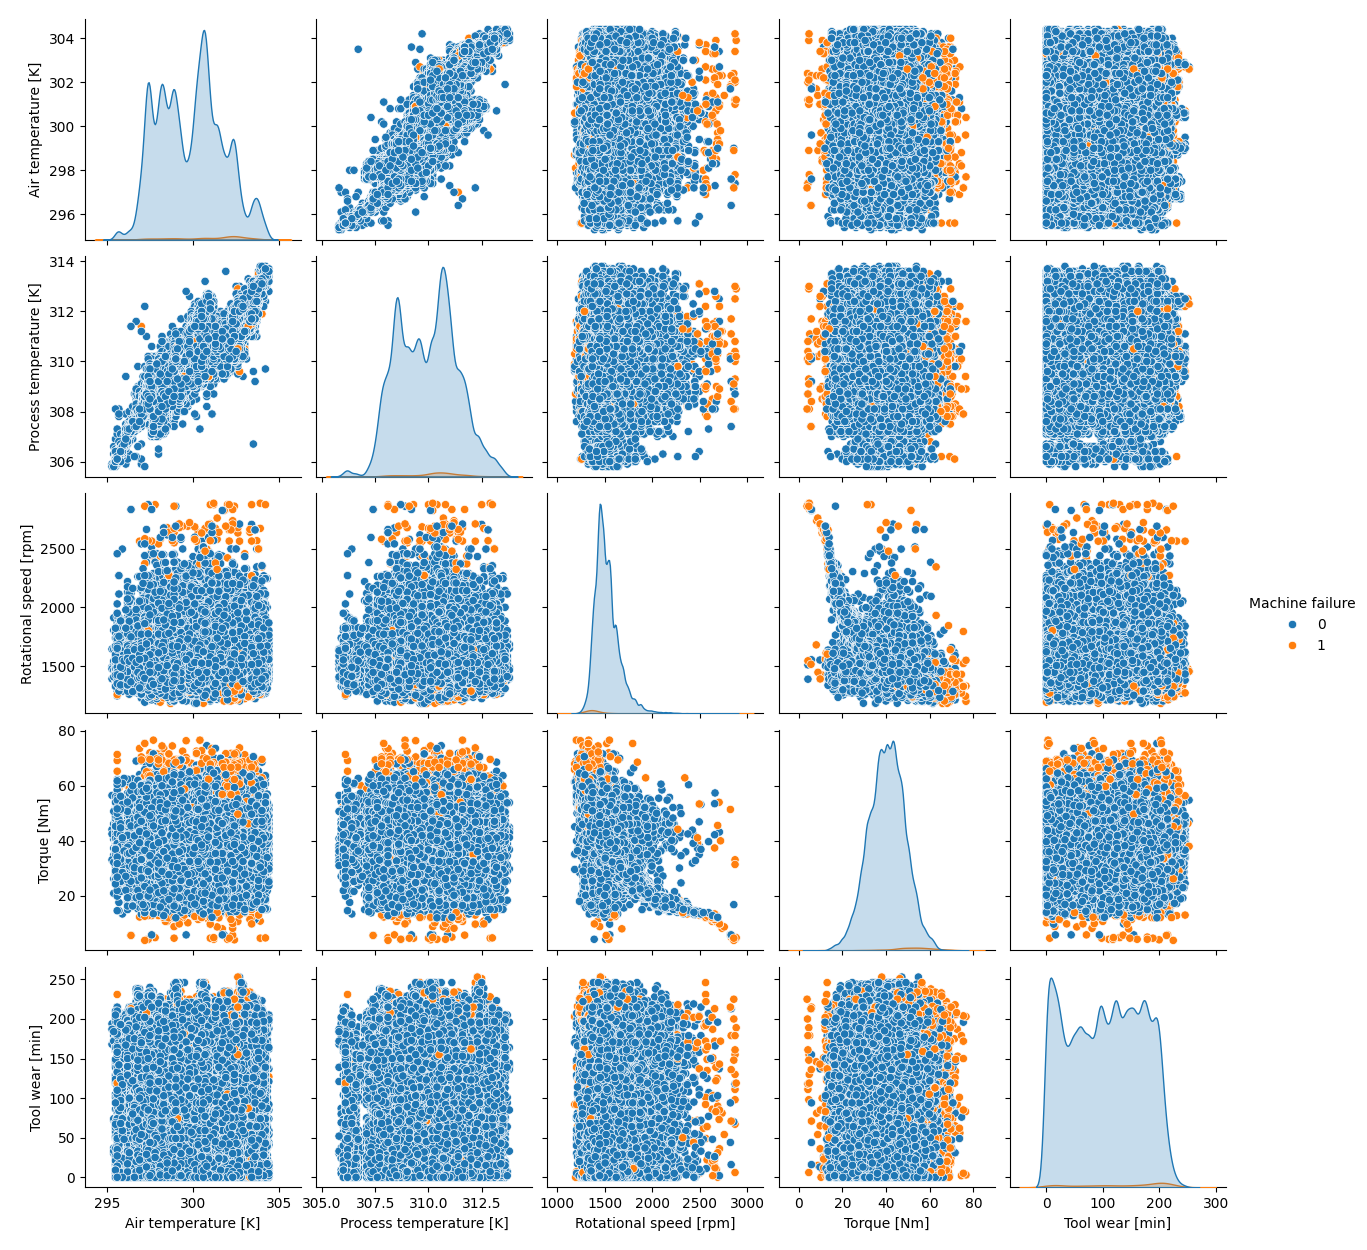

In [71]:
pairplot_or_image(data, "pairplot.png", target, overwrite=False)

## Modelling

In [72]:
X = data.drop(columns=[target], axis=1)
y = data[target]

In [73]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=random_state)

print(f"Train size: {len(Xtr)}")
print(f"Test size: {len(Xte)}")

Train size: 108891
Test size: 27223


### Baseline

In [81]:
from sklearn.tree import DecisionTreeClassifier

base_dt = DecisionTreeClassifier(random_state=random_state)
base_dt.fit(Xtr, ytr)

DecisionTreeClassifier(random_state=69420)

In [82]:
from sklearn.metrics import accuracy_score

ypred = base_dt.predict(Xte)
print(f"Testing accuracy: {accuracy_score(yte, ypred):.3%}")

Testing accuracy: 97.954%


In [83]:
print("Feature importances:")
for i, imp in enumerate(base_dt.feature_importances_):
    print(f"\t{X.columns[i]}: {imp:.3f}")

Feature importances:
	Air temperature [K]: 0.179
	Process temperature [K]: 0.147
	Rotational speed [rpm]: 0.200
	Torque [Nm]: 0.285
	Tool wear [min]: 0.189


In [84]:
base_depth = base_dt.get_depth()
print(f"Tree depth: {base_depth}")

Tree depth: 34


In [127]:
y_pred = base_dt.predict(Xte)

In [130]:
print(classification_report(yte,y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26841
           1       0.31      0.38      0.34       382

    accuracy                           0.98     27223
   macro avg       0.65      0.68      0.67     27223
weighted avg       0.98      0.98      0.98     27223



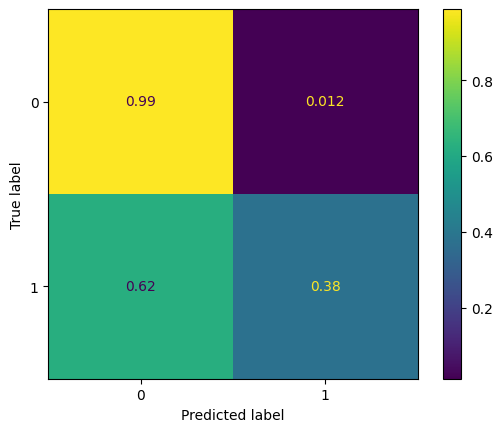

In [137]:
ConfusionMatrixDisplay.from_estimator(base_dt, Xte, yte, display_labels=base_dt.classes_, normalize="true");

### Grid search #1

In [107]:
def grid_search(params, scores):
    skf = StratifiedKFold(n_splits=3, random_state=random_state, shuffle=True)
    results = {}

    for score in scores:
        print(f"Tuning hyperparameters for: {score}...", end="")
        
        clf = GridSearchCV(estimator=base_dt,
                        param_grid=params,
                        scoring=score,
                        return_train_score=False,
                        cv=skf,)
        
        clf.fit(Xtr, ytr)
        
        best_model = clf.best_estimator_
        classes = best_model.classes_
        
        y_pred = best_model.predict(Xte)
        
        report = classification_report(yte,y_pred, zero_division=0)
        cm = confusion_matrix(yte, y_pred, labels=classes, normalize="true")

        results[score] = {
            "model": best_model,
            "report": report,
            "matrix": cm
        }

        print("done")

    return results

In [108]:
def print_gridsearch_results(results):
    for score, res in results.items():
        print("-" * 20)
        print(f"Score: {score}")
        print("Classification report:")
        print(res["report"])
        print(f"Best parameters:")
        print(*[f"\t{n}: {v}" for n, v in res["model"].get_params().items()], sep="\n")

        disp = ConfusionMatrixDisplay(res["matrix"], display_labels=res["model"].classes_)
        disp.plot()
        
        disp.ax_.set_title(f"Optimized for '{score}'")
        disp.ax_.grid(False)

In [158]:
# Set the parameters by cross-validation
params1 = [{'max_depth': [*range(4,base_depth+1)],
           'criterion' : ['entropy', 'gini'],
           "class_weight": [None, "balanced"]
           }]

scores1 = [
          'accuracy',
          'precision_macro',
          'recall_macro',
          'f1_macro'
          ]

results1 = grid_search(params1, scores1)

Tuning hyperparameters for: accuracy...done
Tuning hyperparameters for: precision_macro...done
Tuning hyperparameters for: recall_macro...done
Tuning hyperparameters for: f1_macro...done


--------------------
Score: accuracy
Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     26841
           1       0.60      0.32      0.42       382

    accuracy                           0.99     27223
   macro avg       0.79      0.66      0.70     27223
weighted avg       0.98      0.99      0.99     27223

Best parameters:
	ccp_alpha: 0.0
	class_weight: None
	criterion: entropy
	max_depth: 7
	max_features: None
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	monotonic_cst: None
	random_state: 69420
	splitter: best
--------------------
Score: precision_macro
Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     26841
           1       0.57      0.27      0.37       382

    accuracy                           0.99     27223
   macro avg       0.78      0.63      

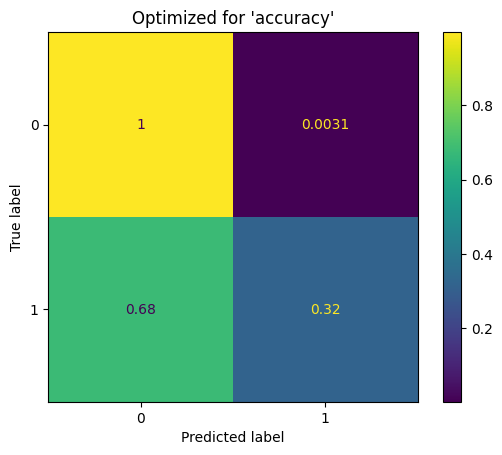

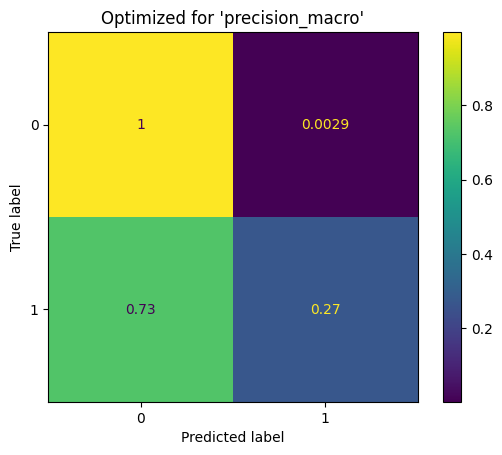

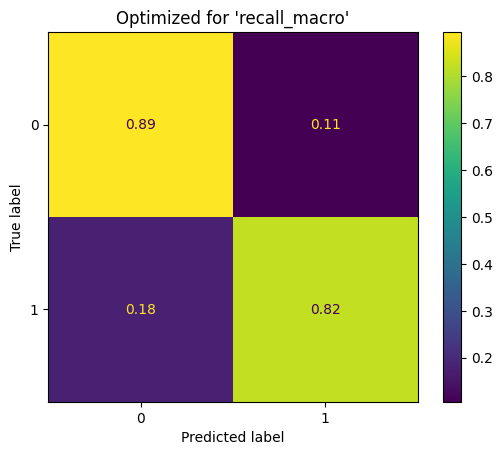

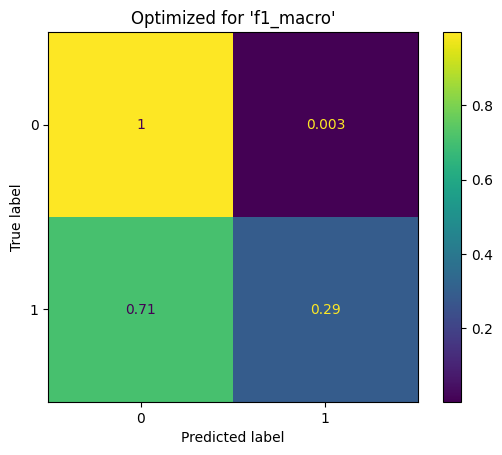

In [159]:
print_gridsearch_results(results1)

From the confusion matrices, we see that the best model is the one optimizing the "recall_macro" metric, which, for the optimized parameters, uses:

- `max_depth` : 4
- `criterion` : `gini`
- `class_weight` : `balanced`

--------------------
Score: recall_macro
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     26841
           1       0.10      0.82      0.18       382

    accuracy                           0.89     27223
   macro avg       0.55      0.86      0.56     27223
weighted avg       0.98      0.89      0.93     27223

Best parameters:
	ccp_alpha: 0.0
	class_weight: balanced
	criterion: gini
	max_depth: 4
	max_features: None
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	monotonic_cst: None
	random_state: 69420
	splitter: best


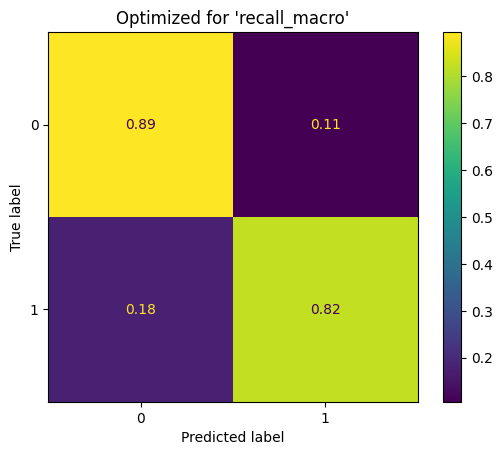

In [160]:
best = "recall_macro"

print_gridsearch_results({best: results1[best]})

### Grid search #2

The previous best model had, however, a lower accuracy (89%) compared to the base model (97.8%) - which in turn had a significantly lower recall macro average of 68%. We use a custom scoring function to find the Decision Tree model that optimizes the recall macro while keeping accuracy at least at 90%

In [170]:
from sklearn.metrics import make_scorer, recall_score
import functools

def custom_scorer(y_true, y_pred, min_accuracy):
    accuracy = accuracy_score(y_true, y_pred)
    recall_macro = recall_score(y_true, y_pred, average='macro')
    
    # Penalize if accuracy falls below 90%
    if accuracy < min_accuracy:
        return 0
    
    # Return recall_macro otherwise
    return recall_macro

custom_scoring = make_scorer(custom_scorer, min_accuracy=0.91)

In [171]:
# Set the parameters by cross-validation
params2 = [{'max_depth': [*range(4,base_depth+1)],
           'criterion' : ['gini'],
           "class_weight": ["balanced"]
           }]

scores2 = [custom_scoring]

results2 = grid_search(params2, scores2)

Tuning hyperparameters for: make_scorer(custom_scorer, response_method='predict', min_accuracy=0.91)...done


--------------------
Score: make_scorer(custom_scorer, response_method='predict', min_accuracy=0.91)
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     26841
           1       0.12      0.75      0.20       382

    accuracy                           0.92     27223
   macro avg       0.56      0.83      0.58     27223
weighted avg       0.98      0.92      0.95     27223

Best parameters:
	ccp_alpha: 0.0
	class_weight: balanced
	criterion: gini
	max_depth: 9
	max_features: None
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	monotonic_cst: None
	random_state: 69420
	splitter: best


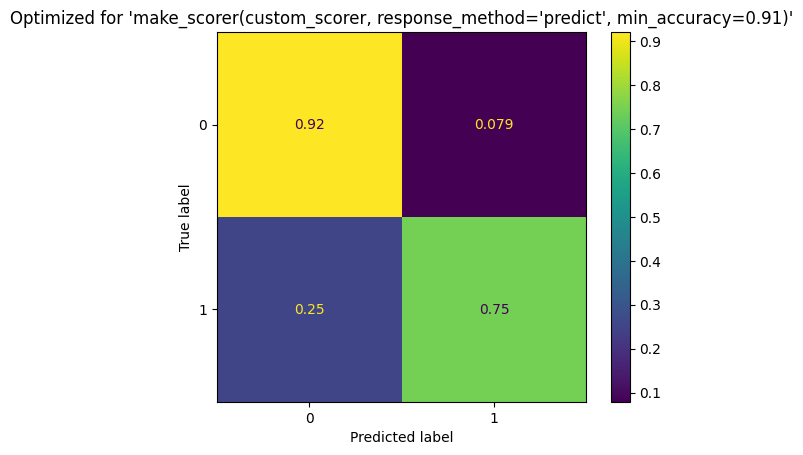

In [172]:
print_gridsearch_results(results2)